# Prospector - Chang catalog

Try to run Prospector on a galaxy from Chang's catalog and compare to known stellar mass / redshift values.

In [9]:
import sedpy 
import prospect
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

import prospect.io.read_results as reader
from prospect.models import SpecModel, SedModel, priors, priors_beta
from prospect.sources import CSPSpecBasis
from prospect.fitting import lnprobfn, fit_model
from prospect.models.templates import TemplateLibrary

Test all the code on one example galaxy:

In [2]:
gal_id = 5

## Load the data

Load the data and look at a single galaxy, `id = 3`.

In [3]:
with fits.open('data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

df.head(3)

,id,ra,dec,redshift,PLATE,MJD,FIBERID,designation,flux0_u,flux0_u_e,...,flux_w2_e,flux_w3,flux_w3_e,flux_w4,flux_w4_e,extin_u,extin_g,extin_r,extin_i,extin_z
0,3,337.450310,1.266134,0.088372,376,52143,404,J222948.07+011558.1,0.000031,0.000003,...,0.000049,4.172000e-07,0.000209,0.000002,0.001187,0.341327,0.265960,0.183990,0.136724,0.101698
1,5,338.115522,1.270146,0.163800,376,52143,567,J223227.69+011612.6,0.000011,0.000004,...,0.000111,9.851000e-07,0.000493,0.000004,0.001883,0.368063,0.286793,0.198402,0.147434,0.109664
2,8,341.101481,1.266255,0.143369,378,52146,404,J224424.38+011558.3,0.000017,0.000003,...,0.000039,1.013700e-06,0.000507,0.000008,0.003856,0.337630,0.263079,0.181997,0.135243,0.100596


### Build an observation

As suggested by [Prospector docs](https://prospect.readthedocs.io/en/latest/dataformat.html), it's good to wrap all the functions needed to load in & organize the data before Prospector run in a single function. Here we take a row from the dataframe for a given object, convert all the fluxes to maggies, and build the dictionary taken as a prospector input. The dictionary keys we need to populate are:

* `filters` : a list of `N` `sedpy` response filters for each object
* `redshift`: (optional) known redshift 
* `maggies` : `Nx1` array of flux densities for the object. $1\:\textrm{maggie} = 10^{-0.4 m_{AB}} = f_{Jy} /3631$
* `maggies_unc`: `Nx1` array with associated uncertainties in the same units

Some things to note:

* Everything in the Chang catalog is in Janskys, so we can convert to Janskys
* We use `flux_x` instead of `flux0_x` values b/c they are corrected for galactic extinction

In [4]:
def build_obs(gal_id):
    """Given an object, load in fluxes, convert them to nanomaggies, and create a dict used in Prospector."""

    inp = {}
    
    # Get dataframe row for the object
    row = df.iloc[gal_id]
    inp['redshift'] = row.redshift

    # Load the filter response curves from sedpy
    bands = [f'sdss_{filt}0' for filt in 'ugriz'] + [f'wise_w{n}' for n in range(1,5)]
    filters = sedpy.observate.load_filters(bands)
    inp['filters'] = filters
    
    # Fluxes and uncertainties - already in units of maggies
    cols = [f'flux_{filt}' for filt in 'ugriz'] + [f'flux_w{n}' for n in range(1,5)]
    fluxes = row[cols].values.astype(float) / 3631

    # Errors
    cols_err = [f'{col}_e' for col in cols]
    errs = row[cols_err].values.astype(float) / 3631

    # Anything with a value of 9.999 is null, so mask those fluxes
    # TODO: check this
    inp['maggies'] = fluxes
    inp['maggies_unc'] = errs

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    inp["phot_wave"] = np.array([f.wave_effective for f in inp["filters"]])
    inp["wavelength"] = None
    
    # Populate other fields with default
    inp = prospect.utils.obsutils.fix_obs(inp)
    return inp

Run on the example galaxy:

In [5]:
obs = build_obs(gal_id)

Plot the observational data and the bandpass curves:

Obs Dictionary Keys:

dict_keys(['redshift', 'filters', 'maggies', 'maggies_unc', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'phot_mask', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4)]


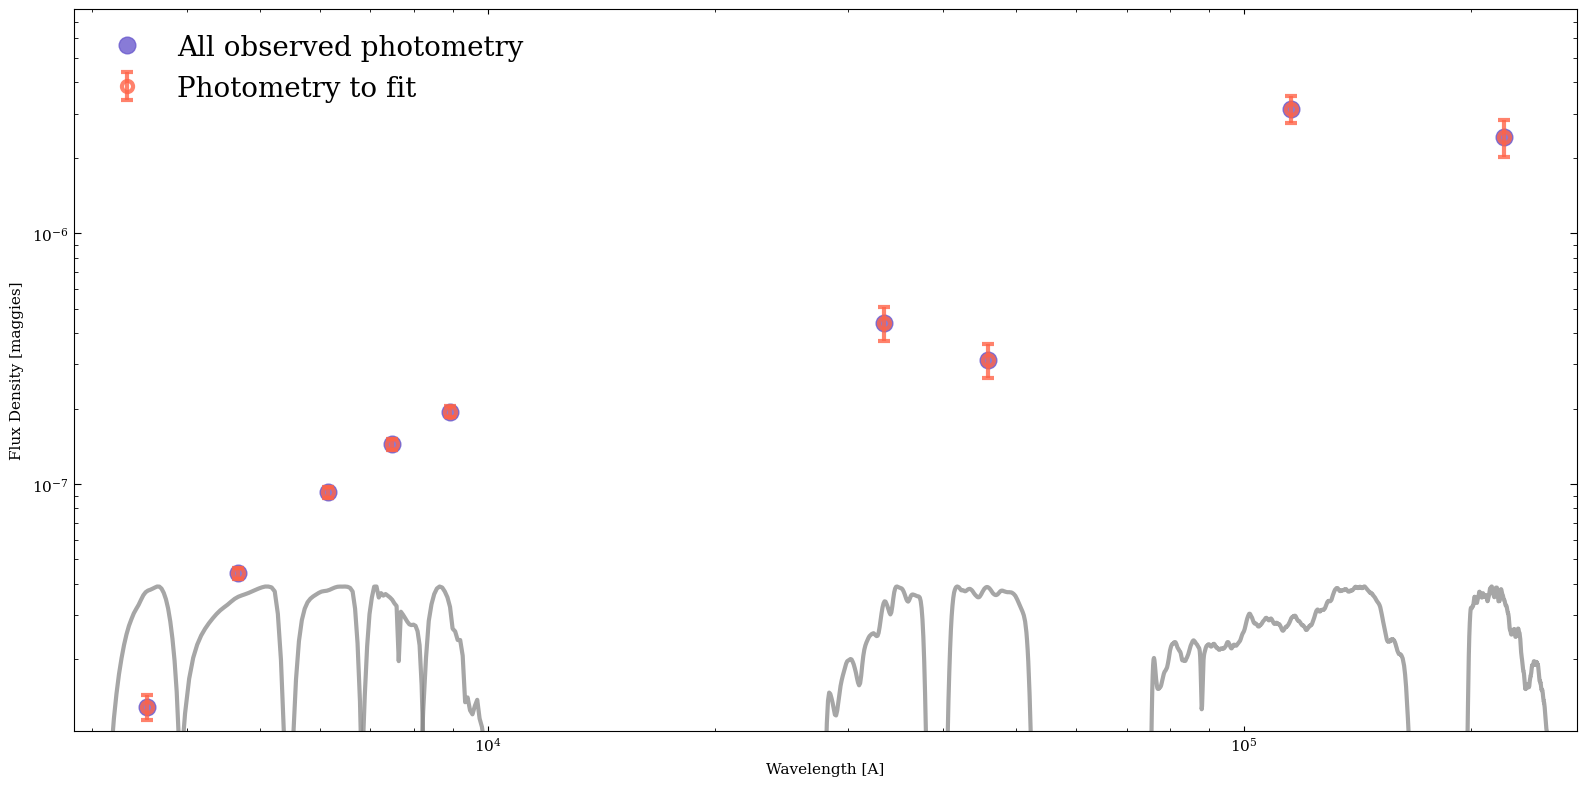

In [6]:

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(16,8))

# plot all the data
plt.plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
plt.errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

## Build model

Next, we have to build a model to fit the SED with. Decision in this step can significantly affect the resulting SED, and there are many things that we could change! The [tutorial](https://prospect.readthedocs.io/en/latest/tutorial.html) has a large section on selecting the model, and the [Models](https://prospect.readthedocs.io/en/latest/models.html) section of the docs has more information.

For the project, we fit a simple model. All different models live in the `TemplateLibrary` directory, and can be viewed with `TemplateLibrary.show_contents()`.

Here we pick a simple parametric SFH model `parametric_sfh`  for a delay-tau SFH. We can add more complicated free parameters, e.g. nebular emission lines, with 

    model_params = TemplateLibrary["parametric_sfh"]
    nebular_params = TemplateLibrary["nebular"]
    model_params.update(nebular_params)

This will replace any keys in the parametric model with the new keys from the nebular model, and add any missing keys as well. Similarly, we can add things like AGN (`agn`), IGM (`igm`), or choose different SFH assumptions.

The model will have many parameters, where some are fixed and some are free to vary (`free: False` or `free: True`). Free parameters need to have an associated [prior](https://prospect.readthedocs.io/en/latest/api/models_api.html#module-prospect.models.priors).

For a simple test, try the **default parameters**

* Parametric SFH (`parametric_sfh`), where $\textrm{SFR} \sim t_{age} e^{-t_{age} / \tau}$
* No nebular, dust, or AGN emission
* Fixed redshift, IMF type, dust type, FSPS SFH model (default values)
    * Redshift `zred`: will given by the spectroscopic redshift
    * SFH model  `sfh`: delayed-tau model from [SFPS](https://github.com/cconroy20/fsps/blob/master/doc/MANUAL.pdf)
    * Dust model `dust_type`: uniform screen dust model from FSPS with a Calzetti dust attenuation
    * IMF model `imf_type`: **can't find any info on this in the docs**
* Varying parameters: mass, metallicity, dust, $t_{age}$, $\tau$
    * Mass prior: log-normal between $8 < \log M < 12$, initial guess $\log M_0 = 10$
    * Metallicity prior: tophat between $-2 < \log Z/Z_\odot < 0.19$, initial guess $\log Z_0/Z_\odot = -0.5$
    * Dust optical depth prior: tophat between $0 < \kappa < 2$, initial guess $\kappa_0 = 0.6$
    * SFR decay timescale: $0.1 < \tau < 30$ Gyr$^{-1}$, initial guess $\tau_0 = 1$ Gyr$^{-1}$
    * SFR time: $0.001 < t_{age} < 13.8$, initial guess $t_{age, 0} = 1$ Gyr
 
**Why are some tutorials using SpecModel and others SedModel?**

In [10]:
model_params = TemplateLibrary['beta'] #TemplateLibrary["parametric_sfh"]

# Set the redshift to known spec-z
# model_params["zred"]["init"] = obs["redshift"]

# Variable redshift
# model_params['zred']['isfree'] = True
# model_params['zred']['init'] = 0.05
# model_params['zred']['prior'] = priors.TopHat(mini=0, maxi=1)

model_params['add_dust_emission']['init'] = False
model_params['add_neb_emission']['init'] = False
model_params['add_neb_continuum']['init'] = False
model_params['fagn']['isfree'] = False
model_params['agn_tau']['isfree'] = False
model_params['add_agn_dust']['init'] = False

model_params['nzsfh']['prior'] = priors_beta.NzSFH(
    zred_mini=0.001,zred_maxi=1.0,mass_mini=8.0,mass_maxi=12.0,z_mini=-1.98,z_maxi=0.19,
    logsfr_ratio_mini=-5.0,logsfr_ratio_maxi=5.0,logsfr_ratio_tscale=0.3,nbins_sfh=7,const_phi=True
)
model = SedModel(model_params)

## Build SPS 

Here we define the stellar population synthesis object. From the [docs](https://prospect.readthedocs.io/en/latest/tutorial.html#):

> For nonparameteric fits one would use the sources.FastStepBasis object. These objects hold all the spectral libraries and produce an SED given a set of parameters.

**Not really sure what `zcontinuous` means and can't find it in the docs?**

At this stage, we could also define some more complicated noise models for our spectroscopic and photometric measurements - but for now we skip this step, assuming all uncertainties are independent and Gaussian.

In [11]:
sps = CSPSpecBasis(zcontinuous=1)

### Plot the initial fit 

(It will be bad as it's not optimized)

In [ ]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them


# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.1, temp.max()/0.4
plt.figure(figsize=(16,8))

# plot model + data
plt.loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

## Running a fit

There are various MCMC samplers available by Prospector and we can input our custom samplers. The two common ones are `emcee` (ensemble sampling) and `dynesty` (dynamic nested sampling). The fitting is done using the `fit_model` function, with parameters

* `obs` : the observation dict made with `build_obs`
* `model`: the model we built
* `sps`: sps defined above
* `noise` : noise model for (specdata, photdata) - by default (None, None) uses independent Gaussian noise
* `lnprobfn`: posterior probability function (**double check this?**), can use the default
* `optimize`: if True, run a round of optimization before sampling, the optimization params can be controlled by keyword args.
* `emcee`: if True, use the emcee sampler (controlled by fitting kwargs)
* `dynesty`: if True, use the dynesty sampler (controlled by fitting kwargs)

In [ ]:
fitting_kwargs = dict(
    nlive_init=400, nlive_batch=200, nested_method="rwalk", nested_target_n_effective=1000, 
    nested_dlogz_init=0.05, nested_maxcall=int(1e7), nested_posterior_thresh=0.05)

output = fit_model(obs, model, sps, optimize=False, dynesty=True, **fitting_kwargs)

Save:

In [18]:
result, duration = output["sampling"]
from prospect.io import write_results as writer
hfile = f"output/gal{gal_id}.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], output["optimization"][0],
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=output["optimization"][1], overwrite=True)

Appending current time (23Dec15-13.11) to output file in order to guarantee a unique name.
New output filename: output/gal5_23Dec15-13.11.h5


/home/liza/miniconda3/envs/prospector/lib/python3.10/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/liza/miniconda3/envs/prospector/lib/python3.10/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/liza/miniconda3/envs/prospector/lib/python3.10/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


## Plot results

Prospector has some convenience plotting functions we can use. First, read in the HDF5 file:

In [21]:
results, obs, model_out = reader.results_from(f"output/gal5_23Dec15-13.11.h5")

### Trace

This shows the evolution of the parameters during optimization as the walkers progress through iterations

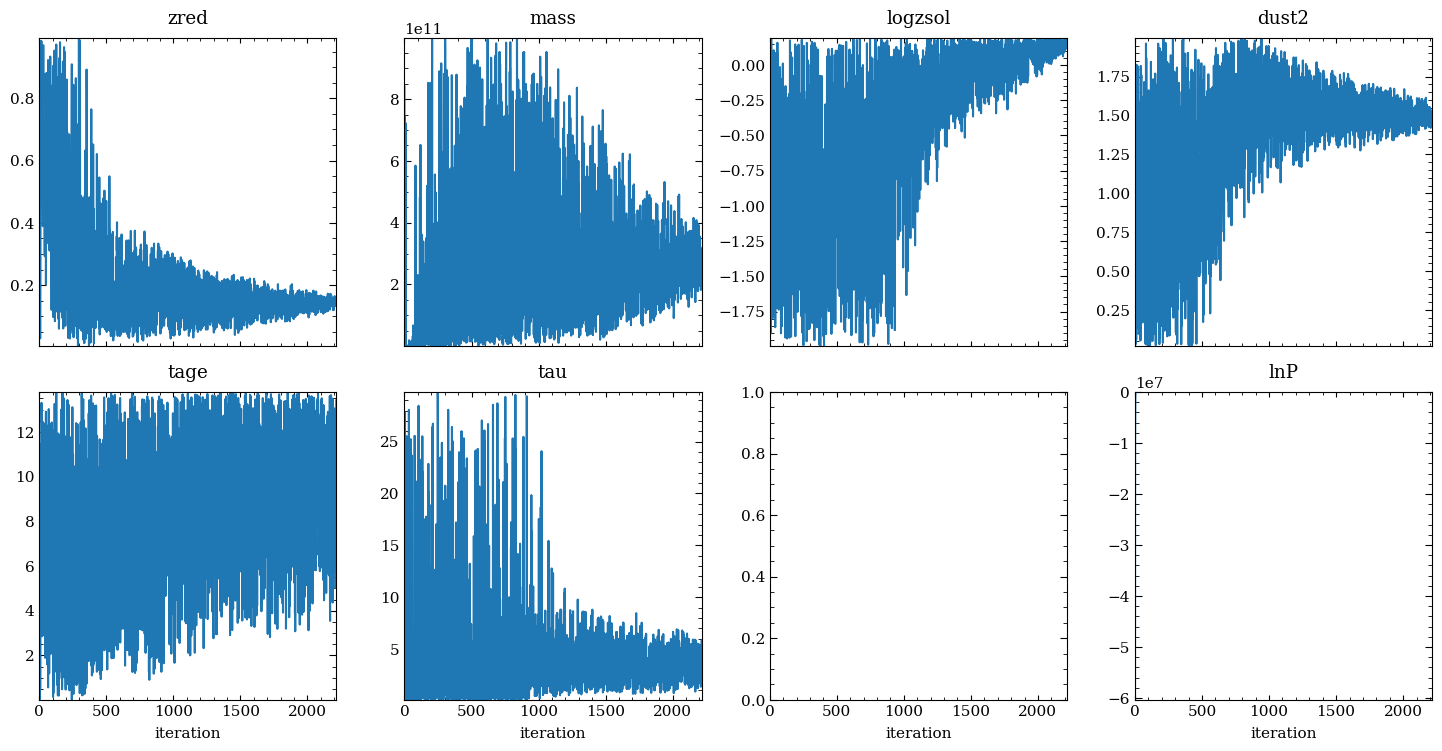

In [22]:
tracefig = reader.traceplot(results)

### Corner plot

Shows the confidence intervals for each parameter pair

In [23]:
from prospect.plotting import corner
from prospect.plotting.utils import best_sample

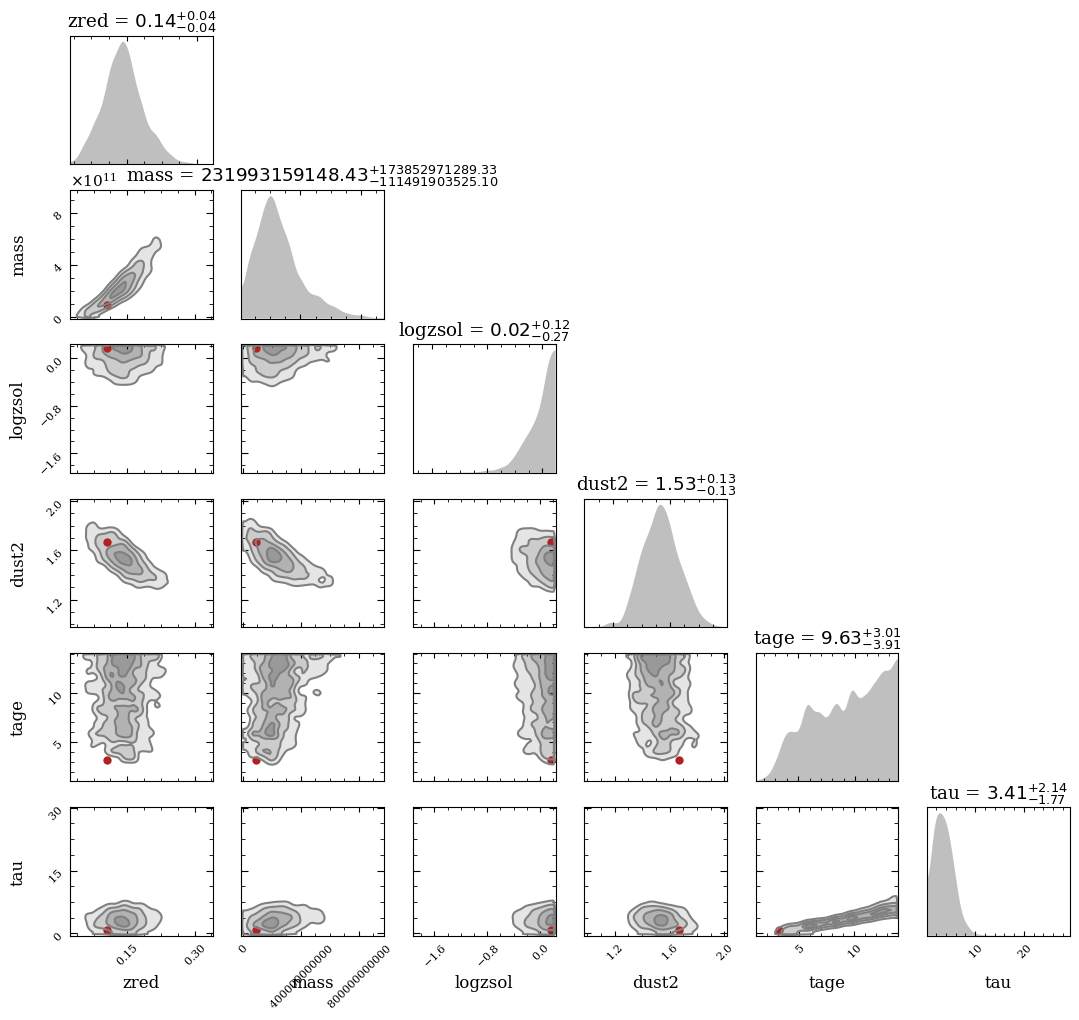

In [24]:
nsamples, ndim = results["chain"].shape
cfig, axes = plt.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(results["chain"].T, results["theta_labels"], axes, weights=results["weights"],show_titles=True, smooth=0.03)
pbest = best_sample(results)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

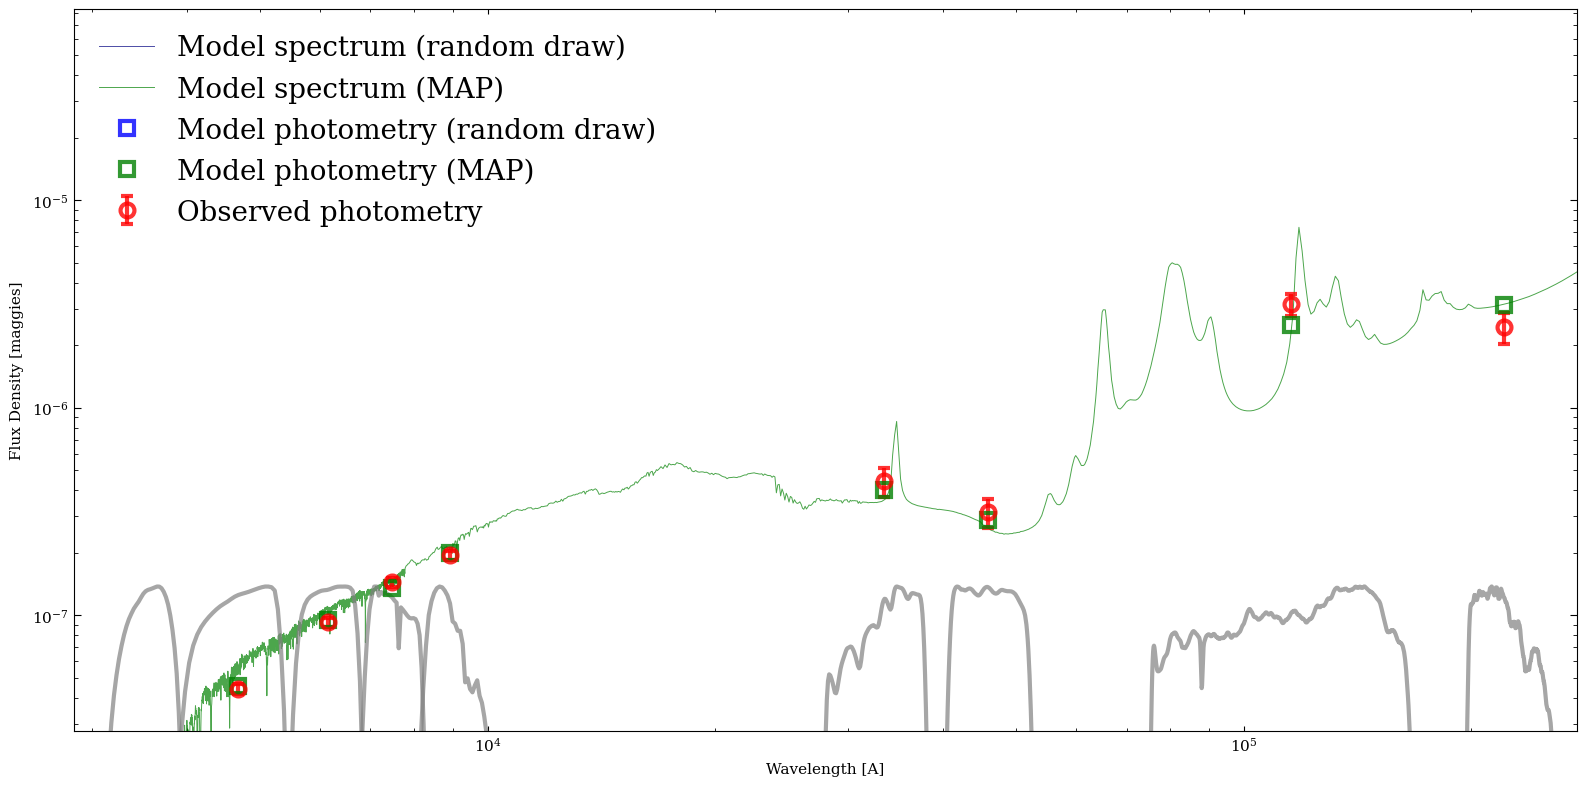

In [25]:
# randomly chosen parameters from chain
randint = np.random.randint
imax = np.argmax(results['lnprobability'])
theta_max = results['chain'][imax, :].copy()
flatchain = results["chain"]
theta = results["chain"][randint(len(results["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

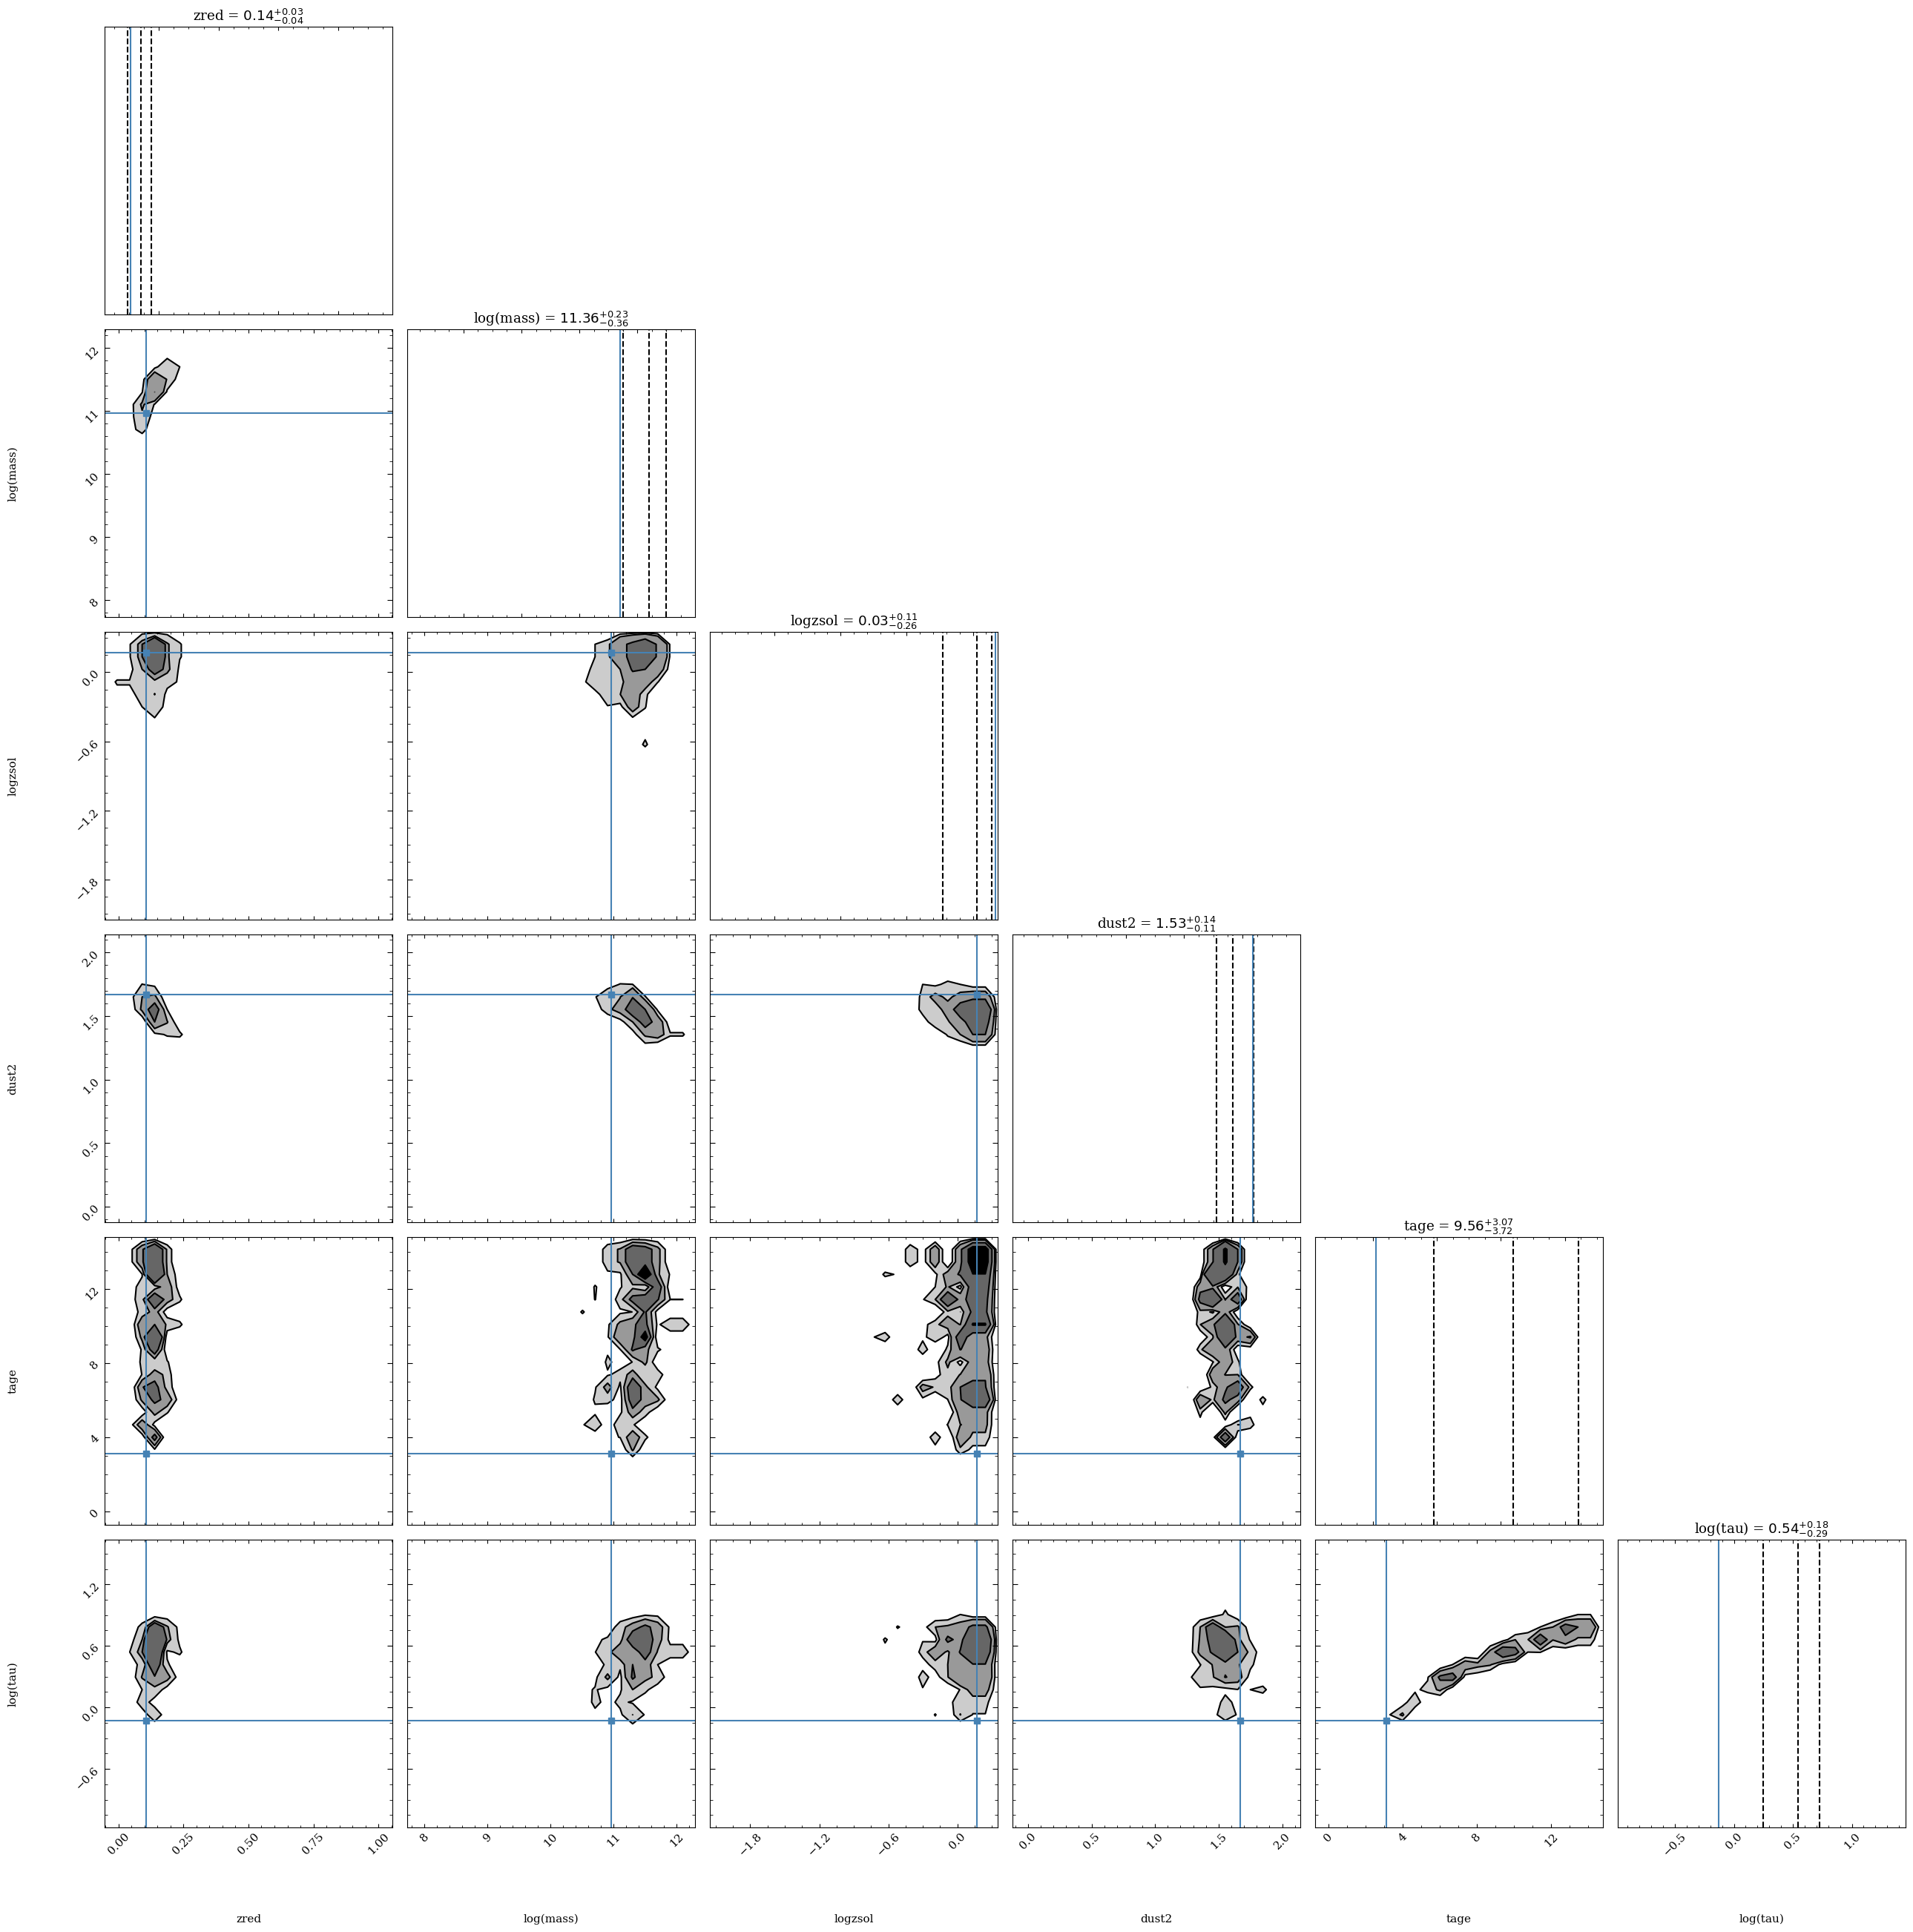

In [26]:
imax = np.argmax(results['lnprobability'])
theta_best = results["chain"][imax, :]
thin = 5
cornerfig = reader.subcorner(results, start=0, thin=thin, truths=theta_best,
                             fig=plt.subplots(6,6,figsize=(27,27))[0])